In [4]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
%matplotlib inline

# The Jaynes-Cummings Model

<img src="jc_model.png",width=400>
<br>
$$
\begin{equation}
H = \hbar\omega_{c}a^{\dagger}a + \hbar\omega_{a}\sigma_{-}^{\dagger}\sigma_{-}+\hbar g(a^{\dagger}\sigma_{-}+a\sigma_{-}^{\dagger})
\end{equation}
$$

This is shorthand notation. If the cavity is system $A$ and atom system $B$ then formally:

$$
\begin{align}
a &= a \otimes \mathbb{I}_{2} \\
\sigma_{-} &= \mathbb{I}_{N} \otimes \sigma_{-}
\end{align}
$$



<h2 style='color:green'>Part #1</h2>

In [5]:
N = 15                 # number of cavity fock states
wc = 1.0  * 2 * np.pi  # cavity frequency
wa = 1.0  * 2 * np.pi  # atom frequency
g  = 0.05 * 2 * np.pi  # coupling strength

# operators
a  = qt.tensor(qt.destroy(N), qt.qeye(2)) # qeye is short for identity
sm = qt.tensor(qt.qeye(N), qt.sigmam())

# Hamiltonian
H = wc * a.dag() * a + wa * sm.dag() * sm + g * (a.dag() * sm + a * sm.dag())

 ## **Note that there is no $\hbar$ anywhere**  The Hamiltonians that are used in QuTiP have units of (typically angular) frequency.  We also do not need to specify the exact units for the frequency (e.g. GHz, MHz, etc.)

<center><h2 style='color:red'>All numerical equations should be unitless.</h2><center>

## When doing time-evolution, the actual units of frequency set the timescale, for example if $\omega = 2\pi\ \mathrm{GHz}$ then the units of time are $\mathrm{ns}$.

What does the full Hamiltonian look like?

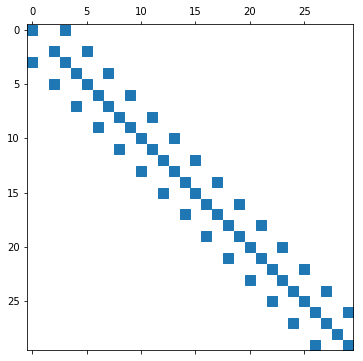

In [6]:
plt.figure(figsize=(8,6))
plt.spy(H.data);

What is the density of non-zero elements?

In [7]:
H.data.nnz / H.shape[0]**2

0.06333333333333334

<h2 style='color:green'>Part #2</h2>

In [8]:
# intial state
psi0 = qt.tensor(qt.basis(N,0), qt.basis(2,0))    # start with an excited atom, cavity ground

# Times over which to evaluate system
tlist = np.linspace(0,25,101)

# Make list of expectation value operators
e_ops = [a.dag() * a, sm.dag() * sm]

#Perform evolution
output = qt.sesolve(H, psi0, tlist, e_ops)

Lets see what `output` is:

In [9]:
output

Result object with sesolve data.
--------------------------------
expect = True
num_expect = 2, num_collapse = 0

The expectation value results are stored in the `expect` attribute of the result class, i.e. `output.expect`.  To see this, lets plot the results.

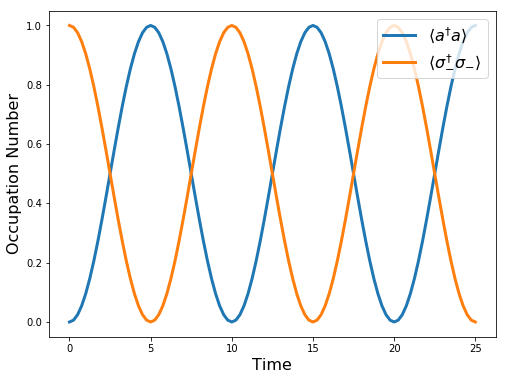

In [10]:
plt.figure(figsize=(8,6))
plt.plot(tlist,output.expect[0], lw=3)
plt.plot(tlist,output.expect[1], lw=3)
plt.legend(['$\langle a^{\dagger}a\\rangle$',
            '$\langle \sigma_{-}^{\dagger}\sigma_{-}\\rangle$'],
           loc=1,fontsize=16)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Occupation Number', fontsize=16);

If instead we want to return the state of the system at time $t$, then we call the same function without the `e_ops`, or setting `e_ops = []`.

In [11]:
#Perform evolution returning state vectors
output = qt.sesolve(H, psi0, tlist, e_ops=[])

In [12]:
output

Result object with sesolve data.
--------------------------------
states = True
num_collapse = 0

<h2 style='color:green'>Part #3</h2>

## Partial trace and entropy

States are stored in the `output.states` attribute. To take the partial trace of a state or operator we use the `Q.ptrace(sel)` method of the Qobj class.  Here `sel` is the index of the desired subsystem(s) that you want to look at.

In [13]:
entropy = np.zeros_like(tlist) # Making an array of zeros
for kk, state in enumerate(output.states):
    rho_cavity = state.ptrace(0)
    entropy[kk] = qt.entropy_vn(rho_cavity)

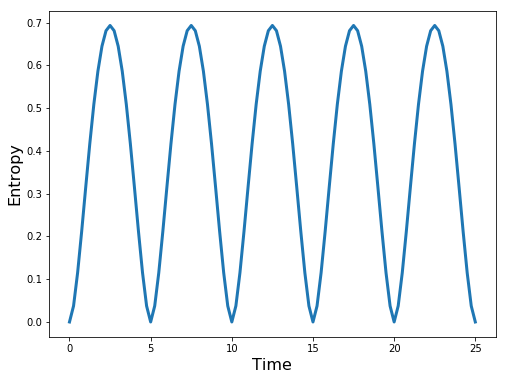

In [14]:
plt.figure(figsize=(8,6))
plt.plot(tlist,entropy,lw=3)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Entropy', fontsize=16);

In [15]:
rho_atom = output.states[np.where(tlist==2.5)[0][0]].ptrace(1)

In [16]:
rho_atom

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.49999279  0.        ]
 [ 0.          0.50000721]]

Verify that the entropy of $\rho_{c}$ is the same as $\rho_{a}$.

In [17]:
np.all([(qt.entropy_vn(state.ptrace(0)) == qt.entropy_vn(state.ptrace(1))) 
        for state in output.states])

True

At times $t=2.5, 7.5, \dots$, atom is in maximally mixed state, and thus entangled with the cavity. This should not be too surprising as the single-exciation in the system is begin eqully shared by the cavity and atom at those times.

## State of the cavity

In [18]:
t_idx = np.where([tlist == t for t in [0.0, 5, 15, 25]])[1]
t_idx

array([  0,  20,  60, 100])

In [19]:
cavity_rho_list = [output.states[kk].ptrace(0) for kk in t_idx]

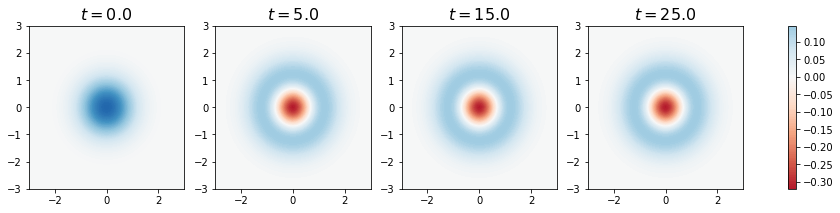

In [20]:
# loop over the list of density matrices

xvec = np.linspace(-3,3,200)

fig, axes = plt.subplots(1,len(cavity_rho_list), sharex=True, 
                         figsize=(4*len(cavity_rho_list),3))

for idx, rho in enumerate(cavity_rho_list):
    # calculate its wigner function
    W = qt.wigner(rho, xvec, xvec)
    # plot its wigner function
    cf = axes[idx].contourf(xvec, xvec, W, 100, vmin=-0.4, vmax=0.4, cmap='RdBu')
    axes[idx].set_title(r"$t = %.1f$" % tlist[t_idx][idx], fontsize=16)
cbar = fig.colorbar(cf, ax=axes.ravel().tolist())

In [21]:
W.sum()*np.diff(xvec)[0]**2

0.99919386620323025

The Wigner distribution of the cavity at times $t=5, 15, 25,\dots$ looks very similar to the $|n\rangle = |1\rangle$ Fock state that we saw earlier.

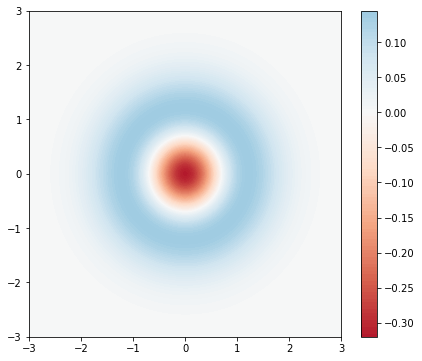

In [22]:
W_fock1 = qt.wigner(qt.basis(N,1), xvec, xvec)
plt.figure(figsize=(7,6))
plt.contourf(xvec, xvec, W_fock1, 100, vmin=-0.4, vmax=0.4, cmap='RdBu')
plt.colorbar();

If we want to make this observation quantitative we can use one of several metrics (distance measures) to see how close our observed state is to a given target state:

#### Fidelity
$$
\begin{equation}
F(\rho, \sigma) = \mathrm{Tr}\left[\sqrt{\sqrt{\rho}\sigma\sqrt{\rho}}\right]
\end{equation}
$$

#### Trace Distance

$$
\begin{equation}
T(\rho, \sigma) = \frac{1}{2}\mathrm{Tr}\left[\sqrt{(\rho-\sigma)^{2}}\right] = \frac{1}{2}\sum_{i} |\lambda_{i}|
\end{equation}
$$

In [23]:
qt.fidelity(qt.basis(N,1),cavity_rho_list[-1])

0.9999999973704953

In [24]:
qt.tracedist(qt.basis(N,1),cavity_rho_list[-1])

0.0